In [1]:
import homophily_functions as fn
import networkx as nx
import pickle as pk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D
import numpy as np
import matplotlib
import copy

In [2]:
import importlib
importlib.reload(fn)

<module 'homophily_functions' from '/home/quint/twitter_network/Soc science paper/homophily_functions.py'>

In [3]:
G = pk.load(open("/home/quint/twitter_network/Pickles/follower_graph.pk", "rb"))  

In [4]:
H = nx.convert_node_labels_to_integers(G)
degs = dict(H.out_degree()).values()

In [5]:
nodes_flt = [key for key,val in dict(H.out_degree()).items() if val>9]
print(len(nodes_flt))

368745


In [6]:
party = fn.ego_percentage_by_category(H, "party_id", False)
party = {key:df.loc[df.Total_ties > 9] for key,df in party.items()}

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1051258/1051258 [00:14<00:00, 70643.47it/s]


In [7]:
nodes_keep = [key for key,val in nx.get_node_attributes(H, "party_reg").items() if not pd.isna(val)]
H_party_reg = copy.deepcopy(H.subgraph(nodes_keep).copy())
party_reg = fn.ego_percentage_by_category(H_party_reg, "party_reg", True, False)
party_reg = {key:df.loc[df.Total_ties > 9] for key,df in party_reg.items()}

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 601457/601457 [00:09<00:00, 60659.44it/s]


In [8]:
len([key for key,val in dict(H_party_reg.out_degree()).items() if val>9])

191192

In [9]:
age = fn.ego_percentage_by_category(H, "binned_age", False)
age = {key:df.loc[df.Total_ties > 9] for key,df in age.items()}

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1051258/1051258 [00:14<00:00, 70569.29it/s]


In [10]:
race_attr = nx.get_node_attributes(H, "race")

race_2 = {key:(val if not val in ["Asian", "Other", "Native American"] else "Asian/Other") for key,val in race_attr.items()}
nx.set_node_attributes(H, race_2, "race_2")
weights_race = {"Caucasian": ((63+66)/2)/86.6, "African-American": 11/6.1,
                "Hispanic":((16+13)/2)/2.5, "Asian/Other": ((10+9)/2)/2.3,
               "Unknown": 0}

race = fn.ego_percentage_by_category(H, "race_2", False, weights_race)
race = {key:df.loc[df.Total_ties > 9] for key,df in race.items()}

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1051258/1051258 [00:16<00:00, 63295.06it/s]


In [11]:
weights_sex = {"Male": ((52+56)/2)/47, "Female":((48+44)/2)/53}
sex = fn.ego_percentage_by_category(H, "gender", False, weights_sex)
sex = {key:df.loc[df.Total_ties > 9] for key,df in sex.items()}

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1051258/1051258 [00:17<00:00, 60854.60it/s]


In [12]:
dist = fn.ego_percentage_by_distance(H, 
                                     [(0,20),(20,100),(100,1000),(1000,5000)], 
                                     False)
dist = dist.loc[dist.Total_ties > 9,]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1051258/1051258 [00:54<00:00, 19454.57it/s]


In [13]:
pop_radius = fn.ego_percentage_by_distance(H, 
                                     [(0,1e5),(1e5,1e6),
                                      (1e6,5e7),(5e7,3.5e8)], 
                                     False,
                                     True)
pop_radius = pop_radius.loc[pop_radius.Total_ties > 9,]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1051258/1051258 [00:52<00:00, 19946.62it/s]


## Plots ##

In [14]:
colors = sns.color_palette("Set2")

AttributeError: 'Legend' object has no attribute 'legendHandles'

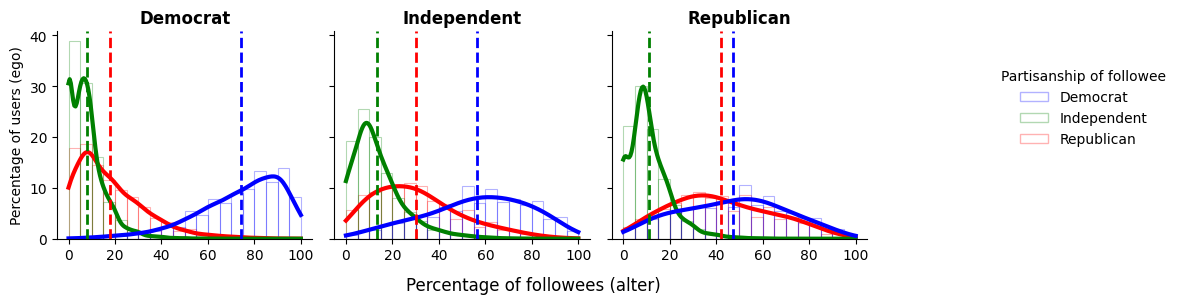

In [24]:
colors = sns.color_palette("Set2")

stats = fn.get_stats(party)

df_party = pd.concat({"Democrat": pd.melt(party["Democrat"][["Democrat", "Independent","Republican"]], var_name = "Partisanship of followee", value_name = "Percentage of followees"),
                "Independent": pd.melt(party["Independent"][["Democrat", "Independent","Republican"]], var_name = "Partisanship of followee", value_name = "Percentage of followees"),
                "Republican": pd.melt(party["Republican"][["Democrat", "Independent","Republican"]], var_name = "Partisanship of followee", value_name = "Percentage of followees")})
df_party = df_party.reset_index(level=0).rename(columns={'level_0': 'subplot'}).reset_index()
df_party["Percentage of followees"] = df_party["Percentage of followees"]*100



g = sns.displot(df_party,
                x = "Percentage of followees",
                hue = "Partisanship of followee",
                col = "subplot",
                kde = True,
                line_kws = {"linewidth":3},
                kde_kws = {"bw_adjust" : 2.5},
                stat = "percent",
                alpha = 0.3,
                fill = False,
                bins = 20,
                common_norm = False,
                palette = ["blue", "green", "red"],
               height = 3, 
               aspect = 1.,
               facet_kws=dict(legend_out=True))

for ax, col_name in zip(g.axes.flat, g.col_names):
    ax.set_title(col_name, fontweight = "bold")
    
color_d = {"Democrat": "blue", "Independent": "green",
           "Republican": "red"}
for ax, col_name in zip(g.axes.flat, g.col_names):
    for dem in g.col_names:
        ax.axvline(stats[0][dem][col_name]*100, color = color_d[dem], linewidth=2, linestyle = '--')
        
g.set_axis_labels("", "Percentage of users (ego)")
g.fig.supxlabel("Percentage of followees (alter)")

sns.move_legend(g, loc = "upper right", ncol = 1, bbox_to_anchor=(1.1, .8))
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)

g._legend.set_title("Partisanship of followee", 
                    matplotlib.font_manager.FontProperties( size = "large"))
g._legend.set_frame_on(True)

g.savefig("Plots/Composition/party.png", dpi = 200)

Alternative party version with different linestyles

AttributeError: 'Legend' object has no attribute 'legendHandles'

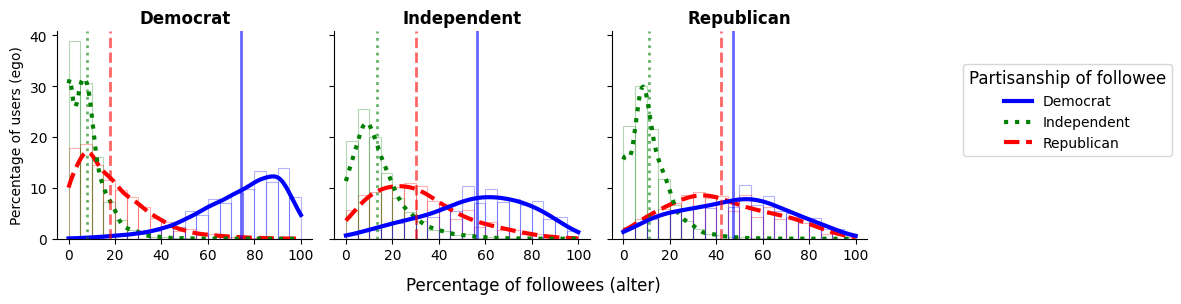

In [23]:
# Start with your original code that produces the plot
colors = sns.color_palette("Set2")
stats = fn.get_stats(party)
df_party = pd.concat({"Democrat": pd.melt(party["Democrat"][["Democrat", "Independent","Republican"]], var_name = "Partisanship of followee", value_name = "Percentage of followees"),
                "Independent": pd.melt(party["Independent"][["Democrat", "Independent","Republican"]], var_name = "Partisanship of followee", value_name = "Percentage of followees"),
                "Republican": pd.melt(party["Republican"][["Democrat", "Independent","Republican"]], var_name = "Partisanship of followee", value_name = "Percentage of followees")})
df_party = df_party.reset_index(level=0).rename(columns={'level_0': 'subplot'}).reset_index()
df_party["Percentage of followees"] = df_party["Percentage of followees"]*100

# Generate the plot first with your original code
g = sns.displot(df_party,
                x = "Percentage of followees",
                hue = "Partisanship of followee",
                col = "subplot",
                kde = True,
                line_kws = {"linewidth":3},
                kde_kws = {"bw_adjust" : 2.5},
                stat = "percent",
                alpha = 0.3,
                fill = False,
                bins = 20,
                common_norm = False,
                palette = ["blue", "green", "red"],
               height = 3, 
               aspect = 1.,
               facet_kws=dict(legend_out=True))

for ax, col_name in zip(g.axes.flat, g.col_names):
    ax.set_title(col_name, fontweight = "bold")
    
color_d = {"Democrat": "blue", "Independent": "green",
           "Republican": "red"}

# Define line styles
linestyle_dict = {
    "Democrat": "-",      # Solid line for Democrats
    "Independent": ":",   # Dotted line for Independents
    "Republican": "--"    # Dashed line for Republicans
}

# HERE'S THE NEW PART: Post-process the lines to set their styles
# For each axes and for each line in the axes, set the line style based on color
for ax in g.axes.flat:
    # Get all line objects in the current axes
    lines = [line for line in ax.get_children() if isinstance(line, matplotlib.lines.Line2D)]
    
    # For each line, check its color and set appropriate style
    for line in lines:
        # Get line color as hex
        line_color = line.get_color()
        
        # Skip vertical lines (which we'll handle separately)
        if line.get_xdata().size == 2 and line.get_xdata()[0] == line.get_xdata()[1]:
            continue
            
        # Check if it's one of our KDE lines by matching color
        if matplotlib.colors.to_hex(line_color) == matplotlib.colors.to_hex("blue"):
            line.set_linestyle(linestyle_dict["Democrat"])
        elif matplotlib.colors.to_hex(line_color) == matplotlib.colors.to_hex("green"):
            line.set_linestyle(linestyle_dict["Independent"])
        elif matplotlib.colors.to_hex(line_color) == matplotlib.colors.to_hex("red"):
            line.set_linestyle(linestyle_dict["Republican"])

# Replace your current vertical lines code with this
for ax, col_name in zip(g.axes.flat, g.col_names):
    for dem in g.col_names:
        ax.axvline(stats[0][dem][col_name]*100, 
                  color=color_d[dem], 
                  linewidth=2,      # Thinner (was 2)
                  linestyle=linestyle_dict[dem],
                  alpha=0.6)        # Add transparency
        
g.set_axis_labels("", "Percentage of users (ego)")
g.fig.supxlabel("Percentage of followees (alter)")

# Create a custom legend with matching line styles
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=3, linestyle='-', label='Democrat'),
    Line2D([0], [0], color='green', lw=3, linestyle=':', label='Independent'),
    Line2D([0], [0], color='red', lw=3, linestyle='--', label='Republican')
]

# Remove the existing legend
if hasattr(g, '_legend') and g._legend is not None:
    g._legend.remove()

# Add our custom legend
g.fig.legend(handles=legend_elements, 
            loc='upper right', 
            bbox_to_anchor=(1.1, 0.8), 
            title="Partisanship of followee", 
            title_fontsize='large', 
            frameon=True)

# Fix the legend handles
for lh in g.fig.legends[0].legendHandles: 
    lh.set_alpha(1)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)
g.savefig("Plots/Composition/party.png", dpi=300)

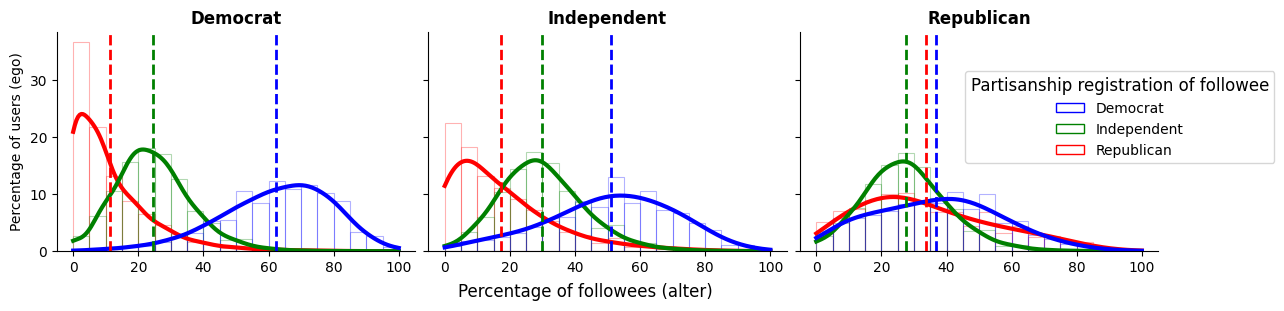

In [31]:
stats = fn.get_stats(party_reg)

df_party_reg = pd.concat({"Democrat": pd.melt(party_reg["Democrat"][["Democrat", "Independent","Republican"]], var_name = "Partisanship registration of followee", value_name = "Percentage of followees"),
                "Independent": pd.melt(party_reg["Independent"][["Democrat", "Independent","Republican"]], var_name = "Partisanship registration of followee", value_name = "Percentage of followees"),
                "Republican": pd.melt(party_reg["Republican"][["Democrat", "Independent","Republican"]], var_name = "Partisanship registration of followee", value_name = "Percentage of followees")})
df_party_reg = df_party_reg.reset_index(level=0).rename(columns={'level_0': 'subplot'}).reset_index()
df_party_reg["Percentage of followees"] = df_party_reg["Percentage of followees"]*100



g = sns.displot(df_party_reg,
                x = "Percentage of followees",
                hue = "Partisanship registration of followee",
                col = "subplot",
                kde = True,
                line_kws = {"linewidth":3},
                kde_kws = {"bw_adjust" : 2.5},
                stat = "percent",
                alpha = 0.3,
                fill = False,
                bins = 20,
                common_norm = False,
                palette = ["blue", "green", "red"],
               height = 3, 
               aspect = 1.,
               facet_kws=dict(legend_out=True))

for ax, col_name in zip(g.axes.flat, g.col_names):
    ax.set_title(col_name, fontweight = "bold")
    
color_d = {"Democrat": "blue", "Independent": "green",
           "Republican": "red"}
for ax, col_name in zip(g.axes.flat, g.col_names):
    for dem in g.col_names:
        ax.axvline(stats[0][dem][col_name]*100, color = color_d[dem], linewidth=2, linestyle = '--')
        
g.set_axis_labels("", "Percentage of users (ego)")
g.fig.supxlabel("Percentage of followees (alter)")

sns.move_legend(g, loc = "upper right", ncol = 1, bbox_to_anchor=(1.1, .8))
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)

g._legend.set_title("Partisanship registration of followee", 
                    matplotlib.font_manager.FontProperties( size = "large"))
g._legend.set_frame_on(True)

g.savefig("Plots/Composition/party_reg.png", dpi = 200)

AttributeError: 'Legend' object has no attribute 'legendHandles'

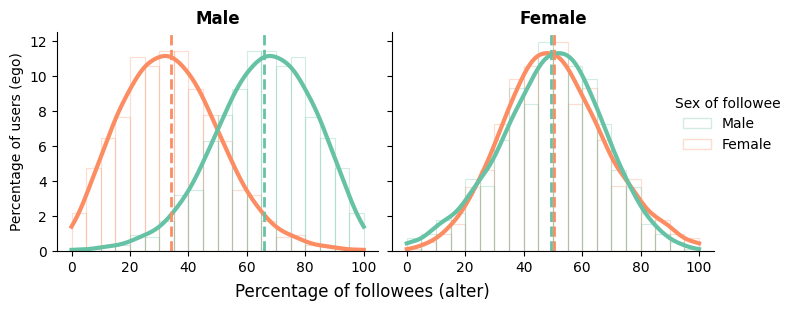

In [15]:
stats = fn.get_stats(sex)


df_sex= pd.concat({"Male": pd.melt(sex["Male"][["Male", "Female"]], var_name = "Sex of followee", value_name = "Percentage of followees"),
                "Female": pd.melt(sex["Female"][["Male", "Female"]], var_name = "Sex of followee", value_name = "Percentage of followees")})
df_sex = df_sex.reset_index(level=0).rename(columns={'level_0': 'subplot'}).reset_index()
df_sex["Percentage of followees"] = df_sex["Percentage of followees"]*100

g = sns.displot(df_sex,
                x = "Percentage of followees",
                hue = "Sex of followee",
                col = "subplot",
                kde = True,
                line_kws = {"linewidth":3},
                kde_kws = {"bw_adjust" : 2.5},
                stat = "percent",
                alpha = 0.3,
                fill = False,
                bins = 20,
                common_norm = False,
                palette = [colors[0], colors[1]],
               height = 3, 
               aspect = 1,
               facet_kws=dict(legend_out=True))

for ax, col_name in zip(g.axes.flat, g.col_names):
    ax.set_title(col_name, fontweight = "bold")
    
color_d = {"Male": colors[0], "Female": colors[1]}
for ax, col_name in zip(g.axes.flat, g.col_names):
    for dem in g.col_names:
        ax.axvline(stats[0][dem][col_name]*100, color = color_d[dem], linewidth=2, linestyle = '--')
        
g.set_axis_labels("", "Percentage of users (ego)")
g.fig.supxlabel("Percentage of followees (alter)")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)

sns.move_legend(g, loc = "center right", ncol = 1, bbox_to_anchor=(1.1, .6))
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
g._legend.set_title("Sex of followee", 
                    matplotlib.font_manager.FontProperties( size = "large"))

g._legend.set_frame_on(True)

g.savefig("Plots/Composition/sex.png", dpi = 200)

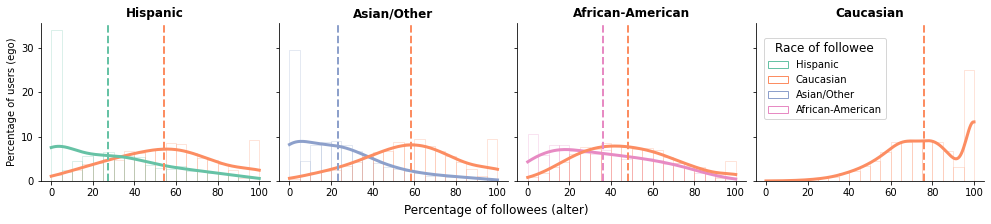

In [23]:
stats = fn.get_stats(race)

df_race = pd.concat({"Hispanic": pd.melt(race["Hispanic"][["Hispanic", "Caucasian"]], var_name = "Race of followee", value_name = "Percentage of followees"),
               "Asian/Other": pd.melt(race["Asian/Other"][["Asian/Other", "Caucasian"]], var_name = "Race of followee", value_name = "Percentage of followees"),
                "African-American": pd.melt(race["African-American"][["African-American", "Caucasian"]], var_name = "Race of followee", value_name = "Percentage of followees"),
               "Caucasian" : pd.melt(race["Caucasian"][["Caucasian"]], var_name = "Race of followee", value_name = "Percentage of followees")})
df_race = df_race.reset_index(level=0).rename(columns={'level_0': 'subplot'}).reset_index()
df_race["Percentage of followees"] = df_race["Percentage of followees"]*100

g = sns.displot(df_race,
                x = "Percentage of followees",
                hue = "Race of followee",
                col = "subplot",
                col_wrap = 4,
                kde = True,
                line_kws = {"linewidth":3},
                kde_kws = {"bw_adjust" : 2.5},
                stat = "percent",
                alpha = 0.3,
                fill = False,
                bins = 20,
                common_norm = False,
                palette = [colors[0], colors[1], colors[2], colors[3]],
               height = 3, 
               aspect = 1)

for ax, col_name in zip(g.axes.flat, g.col_names):
    ax.set_title(col_name, fontweight = "bold")

g.set_axis_labels("", "Percentage of users (ego)")
g.fig.supxlabel("Percentage of followees (alter)")

pairs = df_race[["subplot", "Race of followee"]].value_counts().reset_index(name="count")
pairs = set(zip(pairs.subplot, pairs["Race of followee"]))
color_d = {"Hispanic": colors[0], "Caucasian": colors[1],
           "Asian/Other": colors[2], "African-American":colors[3]}

for ax, col_name in zip(g.axes.flat, g.col_names):
    for dem in g.col_names:
        if (col_name, dem) in pairs:       
            ax.axvline(stats[0][dem][col_name]*100, color = color_d[dem], linewidth=2, linestyle = '--')

    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)
sns.move_legend(g, loc = "right", ncol = 1, bbox_to_anchor=(0.9, .65))
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
g._legend.set_title("Race of followee", 
                    matplotlib.font_manager.FontProperties(size = "large"))
g._legend.set_frame_on(True)

g.savefig("Plots/Composition/race.png", dpi = 300)

In [9]:
colors_age = sns.color_palette("magma", 7)


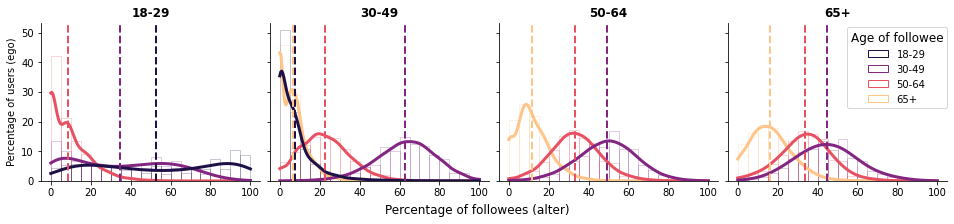

In [24]:
stats = fn.get_stats(age)

df_age = pd.concat({"18-29": pd.melt(age["18-29"][["18-29", "30-49","50-64"]], var_name = "Age of followee", value_name = "Percentage of followees"),
               "30-49": pd.melt(age["30-49"][["18-29", "30-49","50-64", "65+"]], var_name = "Age of followee", value_name = "Percentage of followees"),
                "50-64": pd.melt(age["50-64"][["30-49","50-64", "65+"]], var_name = "Age of followee", value_name = "Percentage of followees"),
               "65+" : pd.melt(age["65+"][["30-49","50-64", "65+"]], var_name = "Age of followee", value_name = "Percentage of followees")})
df_age = df_age.reset_index(level=0).rename(columns={'level_0': 'subplot'}).reset_index()
df_age["Percentage of followees"] = df_age["Percentage of followees"]*100



g = sns.displot(df_age,
                x = "Percentage of followees",
                hue = "Age of followee",
                col = "subplot",
                col_wrap = 4,
                kde = True,
                line_kws = {"linewidth":3},
                kde_kws = {"bw_adjust" : 2.5},
                stat = "percent",
                alpha = 0.3,
                fill = False,
                bins = 20,
                common_norm = False,
                palette = [colors_age[0], colors_age[2], colors_age[4], colors_age[6]],
               height = 3, 
               aspect = 1)

for ax, col_name in zip(g.axes.flat, g.col_names):
    ax.set_title(col_name, fontweight = "bold")
    
g.set_axis_labels("", "Percentage of users (ego)")
g.fig.supxlabel("Percentage of followees (alter)")
    
pairs = df_age[["subplot", "Age of followee"]].value_counts().reset_index(name="count")
pairs = set(zip(pairs.subplot, pairs["Age of followee"]))
color_d = {"18-29": colors_age[0], "30-49": colors_age[2],
           "50-64": colors_age[4], "65+":colors_age[6]}

for ax, col_name in zip(g.axes.flat, g.col_names):
    for dem in g.col_names:
        if (col_name, dem) in pairs:       
            ax.axvline(stats[0][dem][col_name]*100, color = color_d[dem], linewidth=2, linestyle = '--')

    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)
sns.move_legend(g, loc = "right", ncol = 1, bbox_to_anchor=(1, 0.7))
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
g._legend.set_title("Age of followee", 
                    matplotlib.font_manager.FontProperties(size = "large"))
g._legend.set_frame_on(True)

g.savefig("Plots/Composition/age.png", dpi = 300)

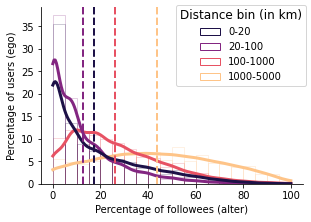

In [25]:
stats = dist.apply(lambda x: np.mean(x)*100, 0).rename(
            {(0, 20): "0-20",
             (20, 100): "20-100",
             (100, 1000): "100-1000",
             (1000, 5000): "1000-5000"}
        )

df_dist = pd.melt(dist.iloc[:,0:4].rename(
            columns = {(0, 20): "0-20",
                       (20, 100): "20-100",
                       (100, 1000): "100-1000",
                       (1000, 5000): "1000-5000"}
        ), 
        var_name = "Distance bin",
        value_name = "Percentage of followees")

df_dist["Percentage of followees"] = df_dist["Percentage of followees"]*100

     
g = sns.displot(df_dist,
                x = "Percentage of followees",
                hue = "Distance bin",
                kde = True,
                line_kws = {"linewidth":3},
                kde_kws = {"bw_adjust" : 2},
                stat = "percent",
                alpha = 0.3,
                fill = False,
                bins = 20,
                common_norm = False,
                palette = [colors_age[0], colors_age[2], colors_age[4], colors_age[6]],
               height = 3, 
               aspect = 1)

color_d = {"0-20": colors_age[0], "20-100": colors_age[2],
           "100-1000": colors_age[4], "1000-5000":colors_age[6]}

g.set_axis_labels("Percentage of followees (alter)", "Percentage of users (ego)")

for dem in color_d.keys():
    g.axes.flat[0].axvline(stats[dem], color = color_d[dem], linewidth=2, linestyle = '--')
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)
sns.move_legend(g, loc = "upper right", ncol = 1)# bbox_to_anchor=(0.55, -0.1))
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
g._legend.set_title("Distance bin (in km)", 
                    matplotlib.font_manager.FontProperties(size = "large"))
g._legend.set_frame_on(True)

g.savefig("Plots/Composition/distance.png", dpi = 300)

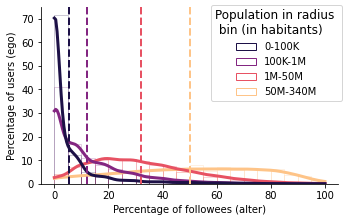

In [10]:
df_pop = pd.melt(pop_radius.iloc[:,0:4].rename(
            columns = {(0, 100000.0): "0-100K",
                       (100000.0, 1000000.0): "100K-1M",
                       (1000000.0, 50000000.0): "1M-50M",
                       (50000000.0, 350000000.0): "50M-340M"}
        ), 
        var_name = "Population in radius bin",
        value_name = "Percentage of followees")

stats = pop_radius.apply(lambda x: np.mean(x)*100, 0).rename(
            {(0, 100000.0): "0-100K",
             (100000.0, 1000000.0): "100K-1M",
             (1000000.0, 50000000.0): "1M-50M",
             (50000000.0, 350000000.0): "50M-340M"}
        )

df_pop["Percentage of followees"] = df_pop["Percentage of followees"]*100


g = sns.displot(df_pop,
                x = "Percentage of followees",
                hue = "Population in radius bin",
                kde = True,
                line_kws = {"linewidth":3},
                kde_kws = {"bw_adjust" : 2},
                stat = "percent",
                alpha = 0.3,
                fill = False,
                bins = 20,
                common_norm = False,
                palette = [colors_age[0], colors_age[2], colors_age[4], colors_age[6]],
               height = 3, 
               aspect = 1)

color_d = {"0-100K": colors_age[0], "100K-1M": colors_age[2],
           "1M-50M": colors_age[4], "50M-340M":colors_age[6]}

g.set_axis_labels("Percentage of followees (alter)", "Percentage of users (ego)")


for dem in color_d.keys():
    g.axes.flat[0].axvline(stats[dem], color = color_d[dem], linewidth=2, linestyle = '--')
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)
sns.move_legend(g, loc = "upper right", ncol = 1)

for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
g._legend.set_title("Population in radius \n bin (in habitants)", 
                    matplotlib.font_manager.FontProperties(size = "large"))
g._legend.set_frame_on(True)

g.savefig("Plots/Composition/pop_radius.png", dpi = 300)

In [11]:
stats

0-100K           5.511106
100K-1M         12.173765
1M-50M          31.851418
50M-340M        50.263974
Total_ties    4127.489184
dtype: float64

### Text Stats

In [24]:
sum(party["Democrat"]["Democrat"] > 0.5)/party["Democrat"].shape[0]

0.8801332213877846

In [8]:
sum(sex["Male"]["Male"]>0.5)/sex["Male"].shape[0]

0.8260310276032516

In [9]:
sum(sex["Female"]["Female"]>0.5)/sex["Female"].shape[0]

0.49645520043563857

In [27]:
sum(race["African-American"]["African-American"] > 0.5)/race["African-American"].shape[0]

0.29852596166615025

In [28]:
sum(race["African-American"]["African-American"] < 0.1)/race["African-American"].shape[0]

0.16847417113009605

In [29]:
sum(age["18-29"]["18-29"] > 0.9)/age["18-29"].shape[0]

0.16792393875820202

In [30]:
sum(age["18-29"]["18-29"] < 0.1)/age["18-29"].shape[0]

0.0953890104003928

In [39]:
sum(dist[(100,1000)]  + dist[(1000,5000)] < 0.5)/dist.shape[0]

0.21942275300327382

In [34]:
dist.columns

Index([(0, 20), (20, 100), (100, 1000), (1000, 5000), 'Total_ties'], dtype='object')

In [42]:
d = list(nx.get_edge_attributes(G, "distance").values())

In [46]:
np.median([x for x in d if not x==None])

np.float64(914.5434593059131)

In [47]:
pop = list(nx.get_edge_attributes(G, "radiation_pop").values())

In [50]:
np.median([x for x in pop if not x==None])

np.float64(74231755.0)